In [1]:
import pandas as pd
import numpy as np
import pyrsm as rsm
import matplotlib.pyplot as plt
import seaborn as sns

# Predictive Modeling
Objective: Predict the price (log-price) of secondhand luxury goods and analyze key features.

In [24]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib.pyplot as plt

In [25]:
# 0. Preparation: Starting from the cleaned v1 in Part A
# Ensure v1 already exists and has no missing values ​
print(v1.shape)
print(v1.isna().mean().mean())
v2 = v1[v1["price_usd"] > 0].copy()
v2["log_price"] = np.log(v2["price_usd"])

(900461, 36)
0.0


In [26]:
# 1. Feature Selection & Simple Feature Engineering
# Numerical Features: Primarily quantity, amount, seller metrics, etc.
numeric_features = [
    "product_like_count",
    "seller_price",
    "seller_earning",
    "buyers_fees",
    "seller_products_sold",
    "seller_num_products_listed",
    "seller_community_rank",
    "seller_num_followers",
    "seller_pass_rate",
]
# Boolean characteristics (0/1): Sold status, inventory status, etc.
bool_features = [
    "sold",
    "reserved",
    "available",
    "in_stock",
    "should_be_gone",
    "has_cross_border_fees",
]
# Category characteristics: brand, product category, gender, season, country, etc.
high_cardinality_cats = [
    "brand_name",
    "product_category",
    "seller_country",
    "product_color",
    "product_material",
]

other_cats = [
    "product_gender_target",
    "product_season",
    "product_condition",
    "seller_badge",
    "warehouse_name",
    "usually_ships_within",
]

categorical_features = high_cardinality_cats + other_cats


# Helper function: Compress columns with too many categories into Top N + "Other"
def reduce_categories(df, col, top_n=20):
    top_values = df[col].value_counts().nlargest(top_n).index
    df[col] = np.where(df[col].isin(top_values), df[col], "Other")


# Compress high-cardinality categories (to avoid dimensionality explosion after one-hot encoding)
for col in high_cardinality_cats:
    reduce_categories(v2, col, top_n=20)

# New Feature Engineering
# 1) Discount percentage (platform price - seller's revenue) / platform price
v2["discount_rate"] = (v2["price_usd"] - v2["seller_earning"]) / v2["price_usd"]

# 2) Total buyer cost = price_usd + buyers_fees
v2["total_buyer_cost"] = v2["price_usd"] + v2["buyers_fees"]

numeric_features_extended = numeric_features + ["discount_rate", "total_buyer_cost"]

# Convert boolean features to 0/1 numeric
for col in bool_features:
    v2[col] = v2[col].astype(int)

In [27]:
# 2. Construct a modeling dataset X, y and split it into training/test sets.
target = "log_price"
feature_cols = numeric_features_extended + bool_features + categorical_features

X = v2[feature_cols].copy()
y = v2[target].copy()

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Train size:", X_train.shape, "Test size:", X_test.shape)

Train size: (720368, 28) Test size: (180093, 28)


In [28]:
# 3. Preprocessing: Numerical standardization + categorical one-hot encoding
numeric_transformer = StandardScaler()
bool_transformer = "passthrough"
categorical_transformer = OneHotEncoder(handle_unknown="ignore", drop=None)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features_extended),
        ("bool", bool_transformer, bool_features),
        ("cat", categorical_transformer, categorical_features),
    ]
)

In [29]:
# 4. Baseline Model: Linear Regression Predicts log(price)
baseline_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        ("model", LinearRegression()),
    ]
)
# Training baseline
baseline_model.fit(X_train, y_train)
# Evaluate on the test set
y_pred_baseline = baseline_model.predict(X_test)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

print("===== Baseline Model: Linear Regression (log_price) =====")
print(f"Test RMSE (log scale): {rmse_baseline:.4f}")
print(f"Test R^2: {r2_baseline:.4f}")

# Cross-validation (5-fold cross-validation on the training set)
neg_mse_scores = cross_val_score(
    baseline_model, X_train, y_train, cv=5, scoring="neg_mean_squared_error"
)
rmse_cv_baseline = np.mean(np.sqrt(-neg_mse_scores))
print(f"5-fold CV RMSE (log scale): {rmse_cv_baseline:.4f}")

===== Baseline Model: Linear Regression (log_price) =====
Test RMSE (log scale): 0.5841
Test R^2: 0.6835
5-fold CV RMSE (log scale): 0.5864


In [30]:
# 5. Improved Model: Random Forest Regression (Nonlinear Relationship + Interaction)
rf_model = Pipeline(
    steps=[
        ("preprocess", preprocessor),
        (
            "model",
            RandomForestRegressor(
                n_estimators=50,
                max_depth=10,
                min_samples_leaf=2,
                n_jobs=-1,
                random_state=42,
            ),
        ),
    ]
)

rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print("\n===== Improved Model: Random Forest (log_price) =====")
print(f"Test RMSE (log scale): {rmse_rf:.4f}")
print(f"Test R^2: {r2_rf:.4f}")

neg_mse_scores_rf = cross_val_score(
    rf_model, X_train, y_train, cv=3, scoring="neg_mean_squared_error"
)
rmse_cv_rf = np.mean(np.sqrt(-neg_mse_scores_rf))
print(f"3-fold CV RMSE (log scale): {rmse_cv_rf:.4f}")


===== Improved Model: Random Forest (log_price) =====
Test RMSE (log scale): 0.0047
Test R^2: 1.0000
3-fold CV RMSE (log scale): 0.0048



Random Forest: RMSE in price units: 13.67 USD


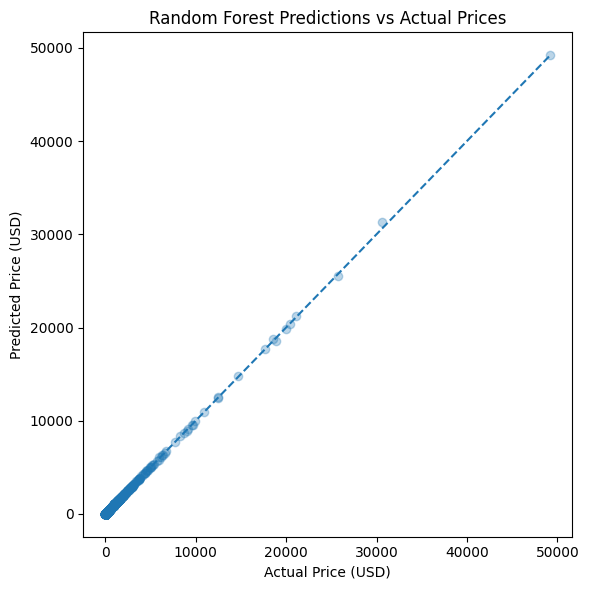

In [31]:
# 6. Convert the log forecast value back to price units to visually assess the error.

# Randomly select a small subset of samples for visualization
sample_idx = np.random.choice(len(y_test), size=5000, replace=False)

y_test_sample = y_test.iloc[sample_idx]
y_pred_rf_sample = y_pred_rf[sample_idx]

# Convert from log-price back to price
actual_price = np.exp(y_test_sample)
pred_price_rf = np.exp(y_pred_rf_sample)

rmse_price_rf = np.sqrt(mean_squared_error(actual_price, pred_price_rf))
print(f"\nRandom Forest: RMSE in price units: {rmse_price_rf:.2f} USD")

plt.figure(figsize=(6, 6))
plt.scatter(actual_price, pred_price_rf, alpha=0.3)
plt.plot(
    [actual_price.min(), actual_price.max()],
    [actual_price.min(), actual_price.max()],
    linestyle="--",
)
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Random Forest Predictions vs Actual Prices")
plt.tight_layout()
plt.show()

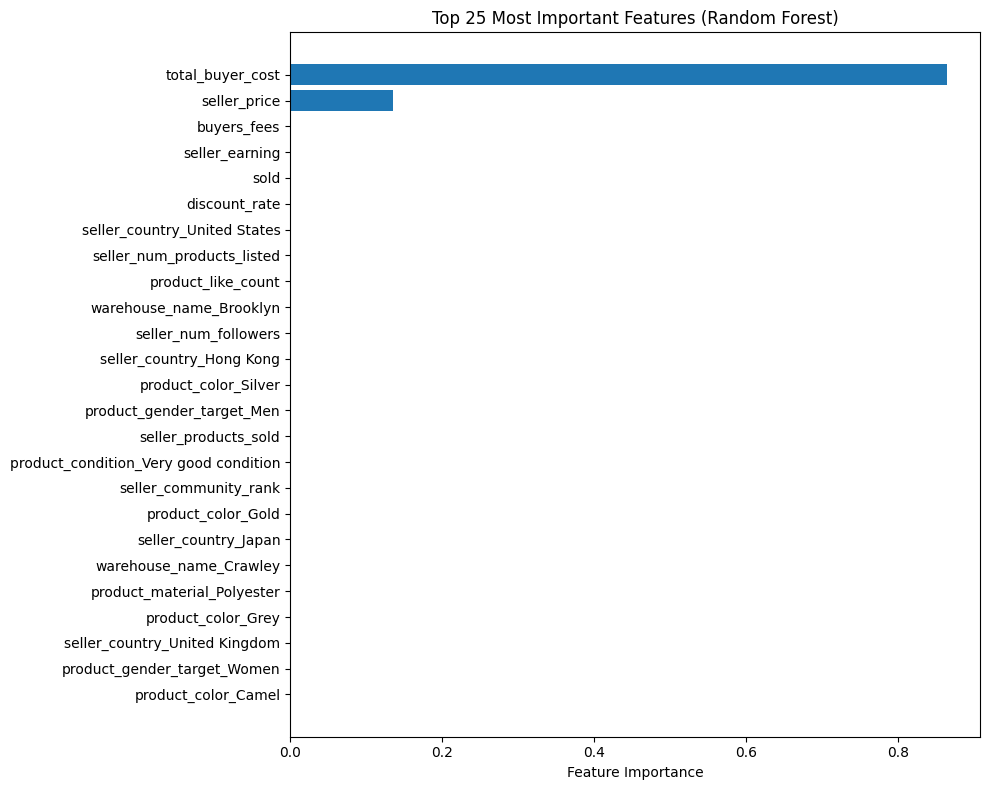

In [32]:
# 7. Feature Importance Analysis (Based on Random Forest)

# Feature names obtained after one-hot encoding
rf_preprocessor = rf_model.named_steps["preprocess"]
rf_estimator = rf_model.named_steps["model"]

num_feature_names = numeric_features_extended
bool_feature_names = bool_features

ohe = rf_preprocessor.named_transformers_["cat"]
cat_feature_names = list(ohe.get_feature_names_out(categorical_features))

all_feature_names = num_feature_names + bool_feature_names + cat_feature_names
importances = rf_estimator.feature_importances_

# Sort and select the top 25 most important features
indices = np.argsort(importances)[::-1]
top_k = 25
top_indices = indices[:top_k]

plt.figure(figsize=(10, 8))
plt.barh(
    [all_feature_names[i] for i in top_indices[::-1]],
    [importances[i] for i in top_indices[::-1]],
)
plt.xlabel("Feature Importance")
plt.title("Top 25 Most Important Features (Random Forest)")
plt.tight_layout()
plt.show()


In [33]:
feature_importance_df = pd.DataFrame(
    {
        "feature": [all_feature_names[i] for i in indices],
        "importance": importances[indices],
    }
)

print(feature_importance_df.head(30))


                                  feature    importance
0                        total_buyer_cost  8.645759e-01
1                            seller_price  1.350682e-01
2                             buyers_fees  1.795693e-04
3                          seller_earning  1.717802e-04
4                                    sold  3.198184e-06
5                           discount_rate  9.372549e-07
6            seller_country_United States  1.800523e-07
7              seller_num_products_listed  3.915456e-08
8                      product_like_count  2.877713e-08
9                 warehouse_name_Brooklyn  1.649317e-08
10                   seller_num_followers  1.112829e-08
11               seller_country_Hong Kong  9.721390e-09
12                   product_color_Silver  9.175253e-09
13              product_gender_target_Men  7.053350e-09
14                   seller_products_sold  5.611024e-09
15  product_condition_Very good condition  4.521352e-09
16                  seller_community_rank  3.683

In [34]:
# for github pages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# 1. predicted vs actual
actual_price = np.exp(y_test)
pred_price = np.exp(y_pred_rf)

rmse_price = np.sqrt(mean_squared_error(actual_price, pred_price))
print(f"Random Forest RMSE in USD: ${rmse_price:,.2f}")

plt.figure(figsize=(6, 6))
plt.scatter(actual_price, pred_price, alpha=0.3)
plt.plot(
    [actual_price.min(), actual_price.max()],
    [actual_price.min(), actual_price.max()],
    linestyle="--",
    color="red",
)
plt.xlabel("Actual Price (USD)")
plt.ylabel("Predicted Price (USD)")
plt.title("Random Forest: Predicted vs Actual Prices")
plt.tight_layout()
plt.savefig("rf_predicted_vs_actual.png", dpi=300)
plt.close()

#  2. features
rf_preprocessor = rf_model.named_steps["preprocess"]
rf_estimator = rf_model.named_steps["model"]

# Get feature names from all transformers
num_feature_names = numeric_features_extended
bool_feature_names = bool_features
cat_feature_names = list(
    rf_preprocessor.named_transformers_["cat"].get_feature_names_out(
        categorical_features
    )
)

all_feature_names = num_feature_names + bool_feature_names + cat_feature_names
importances = rf_estimator.feature_importances_

# top 25
indices = np.argsort(importances)[::-1]
top_idx = indices[:25]

plt.figure(figsize=(10, 8))
plt.barh(
    [all_feature_names[i] for i in top_idx[::-1]],
    [importances[i] for i in top_idx[::-1]],
)
plt.xlabel("Feature Importance")
plt.title("Top 25 Random Forest Feature Importances")
plt.tight_layout()
plt.savefig("rf_feature_importance_top25.png", dpi=300)
plt.close()

print("Exported:")
print("- rf_predicted_vs_actual.png")
print("- rf_feature_importance_top25.png")


Random Forest RMSE in USD: $46.27
Exported:
- rf_predicted_vs_actual.png
- rf_feature_importance_top25.png
